In [185]:
import numpy as np
import pandas as pd
import glob
import os
from omegaconf import OmegaConf
import skimage
from tqdm.notebook import tqdm, trange

In [186]:
# Define parameters here
start_date = "2024-02-19"
max_images = 424242
output_path = "../outputs"
target_path = "../data/raw/train_kelp/"

In [187]:
# Search for suitable output folders
folders = []
confs = dict()
for day_folder in glob.glob(os.path.join(output_path, "*/")):
    if day_folder.split(os.sep)[-2] < start_date:
        continue       
    for timestamp_folder in glob.glob(os.path.join(day_folder, "*/")):
        if not os.path.exists(os.path.join(timestamp_folder, "preds")):
            continue
        
        # read the .hydra/config.yaml file with omegaconf into a dictionary
        with open(os.path.join(timestamp_folder, ".hydra", "config.yaml"), "r") as f:
            cfg = OmegaConf.load(f)
            
        if "test_size" not in cfg or cfg.test_size != 0.2:
            continue
        
        confs[timestamp_folder] = cfg            
        print(timestamp_folder)
        folders.append(timestamp_folder)
print(f"Found {len(folders)} suitable folders")

../outputs\2024-02-19\14-58-07\
../outputs\2024-02-19\15-16-43\
../outputs\2024-02-19\16-01-33\
../outputs\2024-02-19\16-37-53\
../outputs\2024-02-19\16-49-42\
../outputs\2024-02-19\17-22-32\
../outputs\2024-02-19\17-50-54\
../outputs\2024-02-19\18-13-00\
../outputs\2024-02-19\18-40-20\
Found 9 suitable folders


In [188]:
# Filter out folders with identical configurations
unique_confs = dict()
for folder, conf in confs.items():
    if conf not in unique_confs.values():
        unique_confs[folder] = conf
folders = list(unique_confs.keys())
print(f"Remaining folders: {len(folders)}")

Remaining folders: 9


In [189]:
# Read the filenames inside the first folder
filenames = glob.glob(os.path.join(folders[0], "preds", "*.tif"))
image_names = [os.path.basename(f)[:-9] for f in filenames]

In [190]:
# Create a name based on the config
names = dict()
for folder in folders:
    conf = confs[folder]
    name = conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].model.model._target_.split(".")[-1]
    if name == "Unet":
        name = f"{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].model.model.encoder_name}-{name}"
    name += f"-f{len(conf.model.model_loop_pipeline.pretrain_pipeline.pretrain_steps[1].columns)}"
    name += f"-bs{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].batch_size}"
    name += f"-e{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].epochs}"
    name += f"-{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].criterion._target_.split('.')[-1]}"
    names[folder] = name
for folder, name in names.items():
    print(folder, name)

../outputs\2024-02-19\14-58-07\ vgg13-Unet-f18-bs16-e75-FocalDiceBoundaryLoss
../outputs\2024-02-19\15-16-43\ vgg13-Unet-f13-bs16-e75-DiceLoss
../outputs\2024-02-19\16-01-33\ SwinUNETR-f13-bs16-e75-DiceLoss
../outputs\2024-02-19\16-37-53\ vgg13-Unet-f6-bs16-e75-DiceLoss
../outputs\2024-02-19\16-49-42\ vgg13-Unet-f7-bs16-e75-DiceLoss
../outputs\2024-02-19\17-22-32\ vgg13-Unet-f18-bs16-e75-FocalDice2BoundaryLoss
../outputs\2024-02-19\17-50-54\ vgg13-Unet-f13-bs16-e75-FocalDiceBoundaryLoss
../outputs\2024-02-19\18-13-00\ timm-resnest14d-Unet-f13-bs16-e75-DiceLoss
../outputs\2024-02-19\18-40-20\ timm-res2net50_26w_4s-Unet-f13-bs16-e75-DiceLoss


In [191]:
# Take the first max_images images
image_selection = image_names[:min(max_images, len(image_names))]

In [192]:
# Load the target tiffs into an array
targets = []
for image_name in tqdm(image_selection):
    target = skimage.io.imread(os.path.join(target_path, f"{image_name}_kelp.tif"))
    targets.append(target)
targets = np.array(targets).flatten()

  0%|          | 0/1127 [00:00<?, ?it/s]

In [193]:
# Load the predictions into an array
predictions = dict()
for folder in tqdm(folders):
    preds = []
    for image_name in image_selection:
        pred = skimage.io.imread(os.path.join(folder, "preds", f"{image_name}_pred.tif"))
        preds.append(pred)
    predictions[folder] = np.array(preds).flatten()

  0%|          | 0/9 [00:00<?, ?it/s]

In [194]:
# Calculate the dice scores and square error
dice_scores = dict()
square_errors = dict()
for folder, preds in tqdm(predictions.items()):
    preds = preds > 0.5
    dice_scores[folder] = 2 * np.sum(targets * preds) / (np.sum(targets) + np.sum(preds))   
    square_errors[folder] = np.mean((targets - preds) ** 2)

  0%|          | 0/9 [00:00<?, ?it/s]

In [195]:
# Remove all models with dice score below 0.6
folders = [folder for folder in folders if dice_scores[folder] > 0.6]
print(f"Remaining models: {len(folders)}")

Remaining models: 9


In [196]:
# Sort the folders by dice score
folders = sorted(folders, key=lambda folder: dice_scores[folder], reverse=True)

In [197]:
# Create a dataframe with the results
df = pd.DataFrame({
    "name": [names[folder] for folder in folders],
    "dice_score": [dice_scores[folder] for folder in folders],
    "square_error": [square_errors[folder] for folder in folders]
})

In [198]:
# Create a scatterplot with plotly express
import plotly.express as px
fig = px.scatter(df, x="dice_score", y="square_error", text="name")
fig.show()

# Error minimization

In [199]:
# Step 1 of the algorithm, compute error, error mean per base model, and a covariance matrix
errors = np.array([predictions[folder] - targets for folder in folders])
error_means = np.mean(errors, axis=1)
covariance_matrix = np.cov(errors, bias=True)
corr = np.corrcoef(errors)

In [200]:
# Step 2. Define a function to estimate the squared error of the ensemble
def ensemble_error(selection, error_means, covariance_matrix):
    selection = np.array(selection) > 0.5
    return np.mean(error_means[selection])**2 + np.mean(covariance_matrix[selection][:, selection])

In [201]:
# Compute the actual error for comparison
def true_error(selection, errors):
    selection = np.array(selection) > 0.5
    return np.mean(np.mean(errors[selection],axis=0)**2)

In [202]:
# Use timeit to compare the two methods
import timeit
print(f"{timeit.timeit(lambda: ensemble_error(np.ones(len(folders)), error_means, covariance_matrix), number=2):.5}s")
print(f"{timeit.timeit(lambda: true_error(np.ones(len(folders)), errors), number=2):.5}s")

0.0003904s
2.8286s


In [203]:
# Step 3. Go through all possible combinations of models and find the best one
limit = np.inf 
best_error = np.inf
best_selection = None
for i in trange(1,min(2**len(folders),limit)):
    selection = [int(x) for x in bin(i)[2:].zfill(len(folders))]
    err = ensemble_error(selection, error_means, covariance_matrix)
    if err < best_error:
        best_error = err
        best_selection = selection
print("Best square error:", best_error)
print("Confirmation:", true_error(best_selection, errors))
print("Recommended ensemble:", best_selection)
# list the names of the models in the ensemble
for i in range(len(folders)):
    if best_selection[i] > 0.5:
        print(names[folders[i]])

  0%|          | 0/511 [00:00<?, ?it/s]

Best square error: 0.0031153541281741873
Confirmation: 0.0031153576
Recommended ensemble: [1, 0, 1, 1, 0, 1, 1, 0, 0]
vgg13-Unet-f18-bs16-e75-FocalDice2BoundaryLoss
vgg13-Unet-f18-bs16-e75-FocalDiceBoundaryLoss
SwinUNETR-f13-bs16-e75-DiceLoss
timm-res2net50_26w_4s-Unet-f13-bs16-e75-DiceLoss
vgg13-Unet-f6-bs16-e75-DiceLoss


In [204]:
simple_selection = np.array([1,1,1] + [0]*(len(folders)-3))
print(f"Error (lower is better): Optimised: {best_error:.5f}, simple ensemble: {true_error(simple_selection, errors):.5f}, best model: {true_error([1]+[0]*(len(folders)-1), errors):.5f}")

# compute the dice score for the best and the simple selection ensembles
best_preds = np.mean([predictions[folders[i]] for i in range(len(folders)) if best_selection[i] > 0.5], axis=0) > 0.5
simple_preds = np.mean([predictions[folders[i]] for i in range(len(folders)) if simple_selection[i] > 0.5], axis=0) > 0.5
best_dice = 2 * np.sum(targets * best_preds) / (np.sum(targets) + np.sum(best_preds))
simple_dice = 2 * np.sum(targets * simple_preds) / (np.sum(targets) + np.sum(simple_preds))
print(f"Dice (higher is better): Optimised: {best_dice:.5f}, simple ensemble: {simple_dice:.5f}, best model: {dice_scores[folders[0]]:.5f}")

Error (lower is better): Optimised: 0.00312, simple ensemble: 0.00318, best model: 0.00329
Dice (higher is better): Optimised: 0.71266, simple ensemble: 0.71089, best model: 0.70968


In [205]:
# Optimize the weights with linear regression, using svd decomposition, and predictions
from sklearn.linear_model import LinearRegression
X = np.array([predictions[folder] for folder in folders]).T
y = targets
reg = LinearRegression().fit(X, y)
weights = reg.coef_
print(weights)

[ 0.24073002  0.04374982  0.02667022  0.1590023  -0.00877666  0.12159187
  0.1118004   0.02033569  0.05792218]


In [206]:
# Use the weights to calculate the ensemble error
linreg_preds = np.dot(X, weights) > 0.5
linreg_error = np.mean((linreg_preds - y) ** 2)
print(linreg_error)

0.0035064520218025096


# Genetic algorithm

In [207]:
# Define the fitness function
pred_array = np.array([predictions[folder] for folder in folders])
def dice_fitness(selection, pred, target):
    # selection = np.array(selection) > 0.5
    weights = np.array(selection) / sum(selection)
    
    selectio_bin = np.array(selection) > 0
    pred = pred[selectio_bin]
    weights = weights[selectio_bin]
    
    preds = np.dot(pred.T, weights) > 0.5   
    return 2 * np.sum(target * preds) / (np.sum(target) + np.sum(preds))

In [208]:
fitness_memory = dict()
def dice_fitness_memory(selection, pred, target):
    if sum(selection) == 0:
        return 0
    if tuple(selection) in fitness_memory:
        return fitness_memory[tuple(selection)]
    fitness = dice_fitness(selection, pred, target)
    fitness_memory[tuple(selection)] = fitness
    return fitness

In [209]:
# Define the genetic algorithm
import random
values = [0,0.5,1,1.5,2,2.5,3]
def genetic_algorithm(fitness_function, population_size=100, generations=100, mutation_rate=0.1, subsample=1000, subsample_halftime=5, subsample_decay_factor=2):
    population = [[random.choice(values) for _ in range(len(folders))] for _ in range(population_size)]
    for generation in range(generations):
        if generation % subsample_halftime == 0 and subsample_halftime != -1 and subsample > 1:
            pred = pred_array[:,::subsample]
            target = targets[::subsample]
            subsample //= subsample_decay_factor
            subsample = max(subsample, 1)
            fitness_memory.clear()
            print(f"Subsampled to {len(target)}, factor {subsample}")       

        fitness = [dice_fitness_memory(individual, pred, target) for individual in tqdm(population, desc=f"Generation {generation}", leave=True)]
        best_individual = population[np.argmax(fitness)]
        print(f"Generation {generation}, best fitness: {dice_fitness(best_individual, pred_array, targets):.4f}, best individual: {best_individual}")
        new_population = [best_individual]
        
        # scale fitness between 0 and 1
        fitness = np.array(fitness)
        fitness = (fitness - fitness.min()) / (fitness.max() - fitness.min() + 1e-6)
        
        for _ in range(population_size - 1):
            parent1, parent2 = random.choices(population, weights=fitness, k=2)
            child = []
            for gene1, gene2 in zip(parent1, parent2):
                initial = random.choice([gene1, gene2])
                if random.random() < mutation_rate:
                    mutated = initial + random.choice([-0.5, 0, 0.5])
                    child.append(np.clip(mutated, min(values), max(values)))
                else:
                    child.append(initial)
            new_population.append(child)
        population = new_population
    return best_individual

In [210]:
# Run the genetic algorithm
best_individual = genetic_algorithm(dice_fitness, population_size=100, generations=10, mutation_rate=0.1, subsample=500, subsample_halftime=2, subsample_decay_factor=5)

Subsampled to 276115, factor 100


Generation 0:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 0, best fitness: 0.7126, best individual: [2, 1.5, 3, 2, 0, 2, 0.5, 1, 0]


Generation 1:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 1, best fitness: 0.7131, best individual: [3, 0, 2, 2.5, 2, 2.5, 1, 0.5, 1.5]
Subsampled to 1380575, factor 20


Generation 2:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 2, best fitness: 0.7132, best individual: [2, 1.5, 0.5, 2, 0, 1.5, 1, 1, 0]


Generation 3:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 3, best fitness: 0.7136, best individual: [3, 0, 1.5, 1.5, 0.5, 0.5, 1.5, 2, 0.5]
Subsampled to 6902875, factor 4


Generation 4:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 4, best fitness: 0.7134, best individual: [2.5, 1.5, 2, 2.5, 0, 2.5, 1, 0, 0.0]


Generation 5:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 5, best fitness: 0.7147, best individual: [3.0, 0, 0, 2, 0.5, 1.5, 1, 1, 0]
Subsampled to 34514375, factor 1


Generation 6:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 6, best fitness: 0.7147, best individual: [3.0, 0, 0, 2, 0.5, 1.5, 1, 1, 0]


Generation 7:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 7, best fitness: 0.7147, best individual: [3.0, 0, 0, 2, 0.5, 1.5, 1, 1, 0]


Generation 8:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 8, best fitness: 0.7147, best individual: [3.0, 0, 0, 2, 0.5, 1.5, 1, 1, 0]


Generation 9:   0%|          | 0/100 [00:00<?, ?it/s]

Generation 9, best fitness: 0.7147, best individual: [3.0, 0, 0, 2, 0.5, 1.5, 1, 1, 0]


In [211]:
# Print the list
for i in range(len(folders)):
    if best_individual[i] > 0:
        print(best_individual[i], names[folders[i]])

3.0 vgg13-Unet-f18-bs16-e75-FocalDice2BoundaryLoss
2 SwinUNETR-f13-bs16-e75-DiceLoss
0.5 vgg13-Unet-f13-bs16-e75-DiceLoss
1.5 timm-res2net50_26w_4s-Unet-f13-bs16-e75-DiceLoss
1 vgg13-Unet-f6-bs16-e75-DiceLoss
1 vgg13-Unet-f7-bs16-e75-DiceLoss


# Visualisation

C:\Users\EmielW\AppData\Local\Temp\ipykernel_17364\3480941669.py:6: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



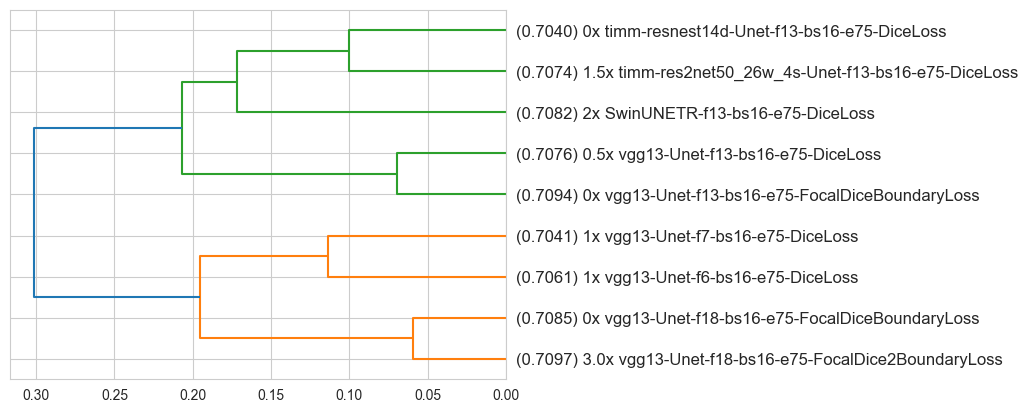

In [212]:
# Treat the correlation as a distance and use hierarchical clustering to group the models
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

labels = [f"({dice_scores[folder]:.4f}) {best_individual[i]}x {names[folder]}" for i, folder in enumerate(folders)]
dendrogram = sch.dendrogram(sch.linkage(1 - corr, method='ward'), labels=labels, orientation="left")
# add the names of the models to the x-axis
plt.show()

In [215]:
# Use PCA to visualise the models in 2D with the correlation as distance
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(1 - corr)

# plot with plotly express interactive
fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], text=[f"({dice_scores[folder]:.4f}) {names[folder][:14]}" for folder in folders])
fig.show()

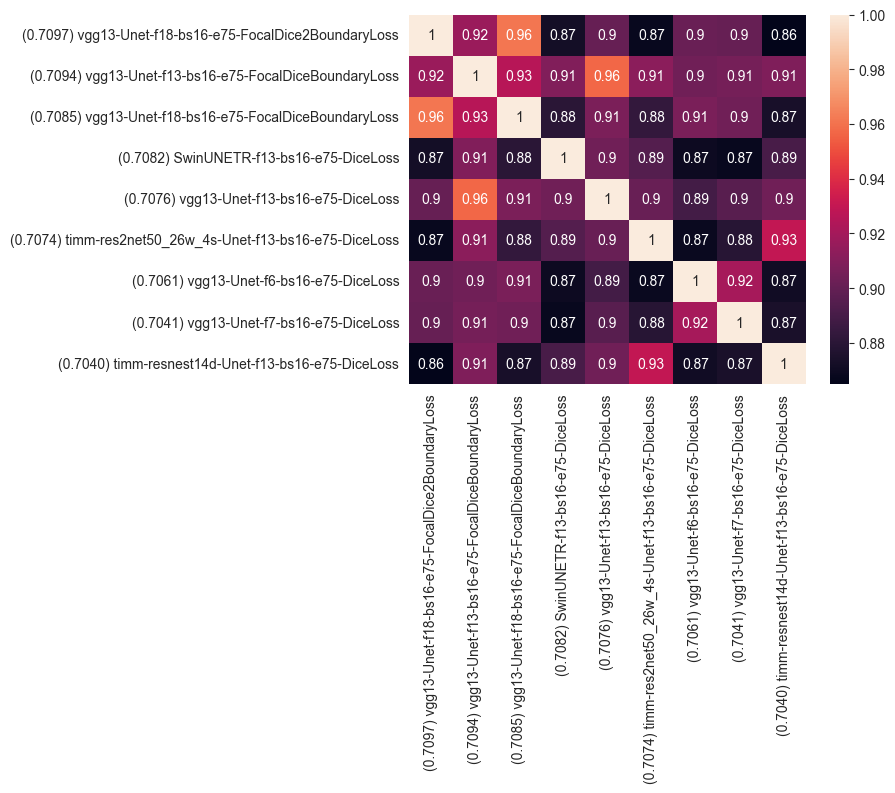

In [216]:
# show the correlation matrix heatmap
import seaborn as sns
sns.heatmap(corr, xticklabels=[f"({dice_scores[folder]:.4f}) {names[folder]}" for folder in folders], yticklabels=[f"({dice_scores[folder]:.4f}) {names[folder]}" for folder in folders], annot=True)
plt.show()